In [172]:
from models import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta
import matplotlib.animation as animation
from scipy.stats import norm
from tqdm import tqdm

### Helper functions

In [158]:
def Plot_agent_performing_task(actions, observations, pi, p_trans, p_r, Gs):
    
    T = len(actions) # Number of trials
    
    for t in range(T):
        
        trial_actions = actions[t]
        
        trial_action_first_stage = trial_actions[0]
        
        trial_action_second_stage = trial_actions[1]
        
        trial_observations = observations[t]
        
        second_stage_state = trial_observations[0]
        
        reward = trial_observations[1]
        
        trial_EFEs = Gs[t]
        
        print("TRIAL: "+str(t+1))
        
        if trial_action_first_stage == 0:
            print("First stage action: a_A")
        else:
            print("First stage action: a_B")
            
        if second_stage_state == 0: 
            print("Second stage state: PINK")
        else:
            print("Second stage state: BLUE")
        
        if trial_action_second_stage == 0:
            print('Second stage action: a_A')
        else:
            print('Second stage action: a_B')
        
        print("Observation: "+str(reward))
        
        # Plot priors over reward probabilities 
        
        plt.figure(figsize=(6, 3))
             
        categories = [r'$\theta_{A}^{Pink}}$', 
                      r'$\theta_{B}^{Pink}}$', 
                      r'$\theta_{A}^{Blue}}$',
                      r'$\theta_{B}^{Blue}}$']  
        
        pi_interesting = pi[t,1]
        
        theta_BA = pi_interesting[1,2]/(pi_interesting[0,2] + pi_interesting[1,2]) 
        theta_BB = pi_interesting[1,3]/(pi_interesting[0,3] + pi_interesting[1,3])
        theta_CA = pi_interesting[1,4]/(pi_interesting[0,4] + pi_interesting[1,4])
        theta_CB = pi_interesting[1,5]/(pi_interesting[0,5] + pi_interesting[1,5])
        
        gen_model_probs = [theta_BA, theta_BB, theta_CA, theta_CB] 
        
        gen_process_probs = [p_r[0,0,t], p_r[0,1,t], p_r[1,0,t], p_r[1,1,t]] 

        
        # Number of categories
        n_categories = len(categories)

        x = np.arange(n_categories) 

        bar_width = 0.35

        plt.bar(x - bar_width/2, gen_model_probs, width=bar_width, label='Generative Model (belief distr)')  
        plt.bar(x + bar_width/2, gen_process_probs, width=bar_width, label='Generative Process (true distr)') 
        plt.title('Prior over reward probabilities')
        plt.xlabel('Reward probability for each final action')
        plt.ylabel('Reward probability')
        plt.grid()
        
        plt.ylim(0,1)

        plt.xticks(x, categories) 
        plt.legend()

        plt.show()
        
        # Plot EFE of first stage actions
        
        plt.figure(figsize=(4, 3))
        
        categories = [r'$a_{A}$', r'$a_{B}$']  
        
        a_A_EFE = trial_EFEs[0,0]
        a_B_EFE = trial_EFEs[0,1]
        
        EFE_vals = [a_A_EFE, a_B_EFE]

        plt.bar(categories, EFE_vals)
        plt.title('First stage action EFEs')
        plt.ylabel('EFE')

        plt.show()
        
        # Plot EFE of second stage actions
        
        plt.figure(figsize=(4, 3))
        
        categories = [r'$a_{A}$', '$a_{B}$']  
        
        if second_stage_state == 0:
            a_A_EFE = trial_EFEs[1,0]
            a_B_EFE = trial_EFEs[1,1]
        else:
            a_A_EFE = trial_EFEs[2,0]
            a_B_EFE = trial_EFEs[2,1]
        
        EFE_vals = [a_A_EFE, a_B_EFE]

        plt.bar(categories, EFE_vals)
        plt.title('Second stage action EFEs')
        plt.ylabel('EFE')

        plt.show()
        
       
        print("------------------------------------------")


In [132]:
def Play_bernoulli_game(p):
    random_number = np.random.uniform(0, 1)
    if random_number <= p:
        print("Observation: 1")
    else:
        print("Observation: 0")

## Preferred observations distribution

In [28]:
def Plot_preferred_obs_distr(lam):
    
    prob_1 = np.exp(lam)/(np.exp(-lam)+np.exp(lam))
    
    prob_0 = np.exp(-lam)/(np.exp(-lam)+np.exp(lam))
    
    categories = ["No reward", "Reward"]
    
    values = [prob_0,prob_1]
    
    plt.figure(figsize=(5, 4))
    
    plt.bar(categories,values)
    
    plt.grid()
    
    plt.ylim(0, 1)
    
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    plt.ylabel("Probability")
    
    plt.title("Preferred observations prior")
    
    plt.show()

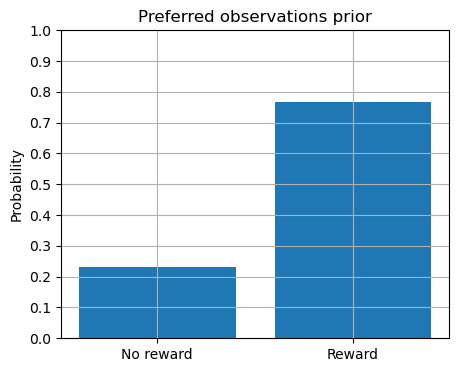

In [31]:
Plot_preferred_obs_distr(lam=0.6)

## The beta distribution

In [93]:
def Plot_beta_distr(alpha_param,beta_param):
    x = np.linspace(0, 1, 100)
    y = beta.pdf(x, alpha_param, beta_param)
    plt.figure(figsize=(5, 4))
    plt.plot(x, y, label=f'Beta Distribution\nα={alpha_param}, β={beta_param}', color='blue')
    plt.title('Beta Distribution')
    plt.xlabel('x')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('Probability Density')
    plt.grid()
    plt.legend()
    plt.show()

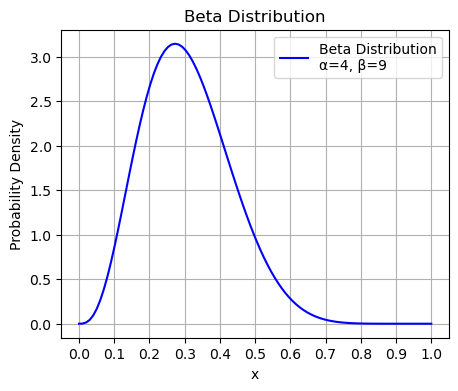

In [100]:
Plot_beta_distr(alpha_param = 4, beta_param = 9)

In [92]:
Play_bernoulli_game(p=0.3)

Observation: 0


## Active inference agents

In [200]:
task_dict = {
    "type": "drift", # How outcome probabilities vary
    "T": 60, # number of trials
    "x": False, # Whether transition probabilities are resampled
    "r": False, # Whether outcome probabilities are resampled
    "delta": 0, # The volatility of task statistics (variance of Gaussian for drift-version)
    "bounds": [0.25,0.85]# List of 2 floats; lower and upper bounds of (final-stage) outcome probabilities
}

model_dict = {
    "act": "AI",
    "learn": "PSM",
    "learn_transitions": False,
    "lam": 1, # Precision over prior preferences
    "lr": 1, # Learning rate
    "vunsamp": 0, #volatility/decay rate for beliefs of unsampled actions (degree of forgetting)
    "vsamp": 0, # volatility/decay rate for beliefs of sampled actions
    "vps": 0, # rate of predictive surprise influence on beliefs
    "gamma1": 1,  # temperature parameter for first stage softmax
    "gamma2": 1, # temperature parameter for second stage softmax
    "kappa_a": 0, # precision of action-repetition habit
    "prior_r": 0.5, # prior outcome probability   
}

In [201]:
agent = learn_and_act(task = task_dict, model = model_dict)

In [202]:
actions, observations, pi, p_trans, p_r, Gs = agent.perform_task()

TRIAL: 1
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 0


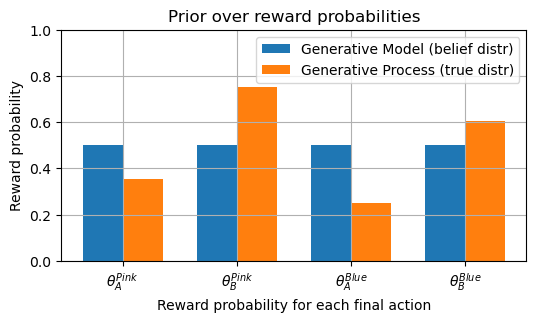

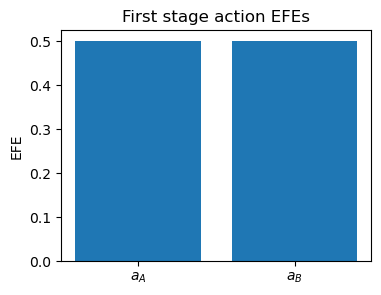

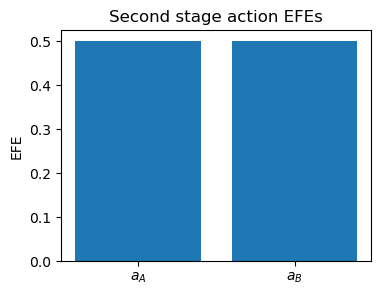

------------------------------------------
TRIAL: 2
First stage action: a_B
Second stage state: PINK
Second stage action: a_B
Observation: 1


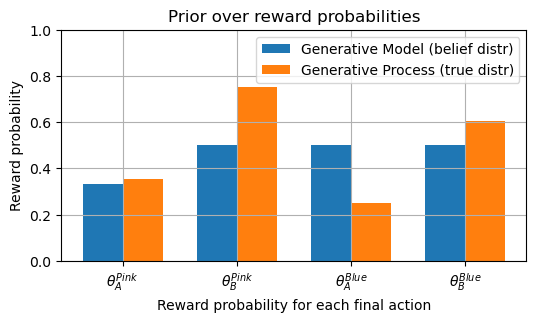

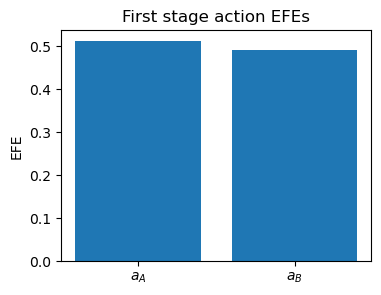

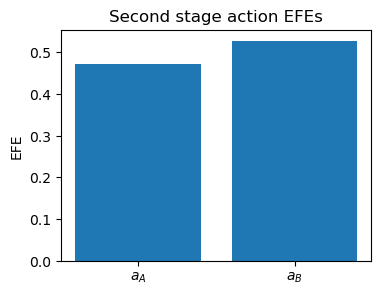

------------------------------------------
TRIAL: 3
First stage action: a_A
Second stage state: BLUE
Second stage action: a_B
Observation: 0


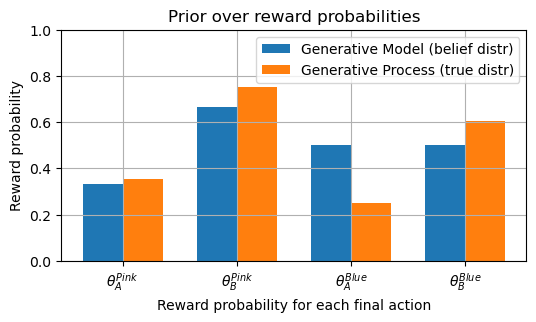

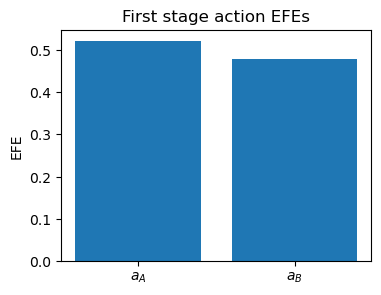

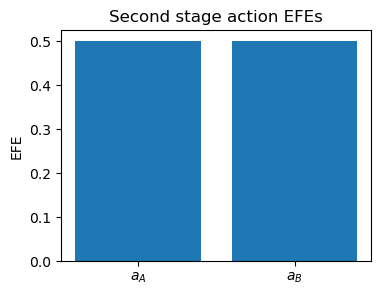

------------------------------------------
TRIAL: 4
First stage action: a_B
Second stage state: PINK
Second stage action: a_B
Observation: 1


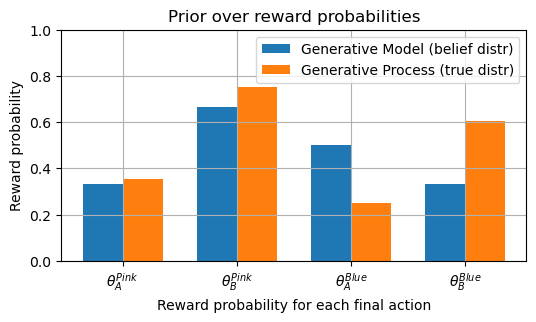

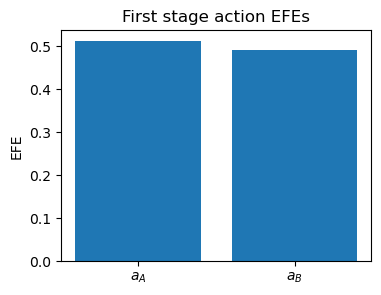

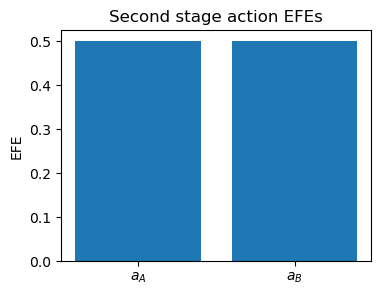

------------------------------------------
TRIAL: 5
First stage action: a_A
Second stage state: BLUE
Second stage action: a_A
Observation: 0


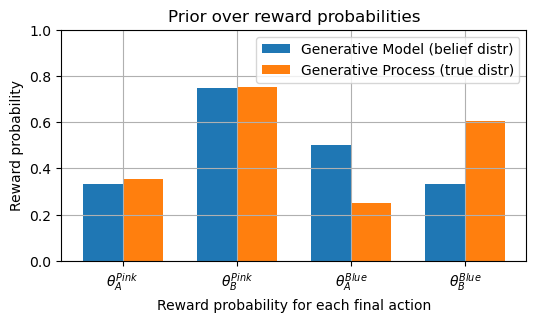

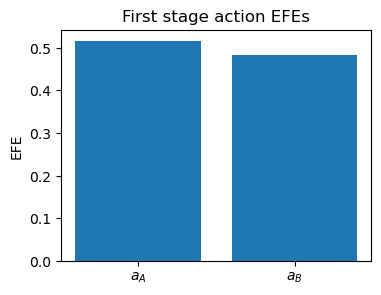

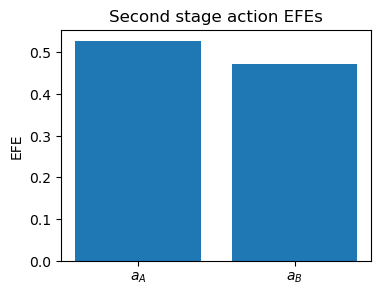

------------------------------------------
TRIAL: 6
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


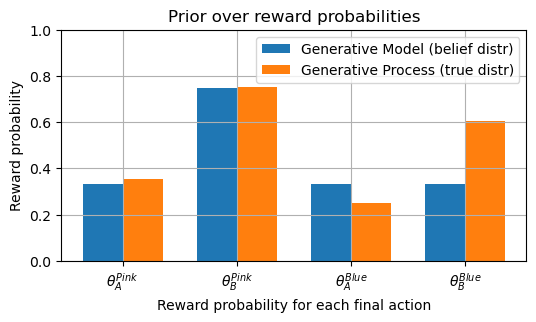

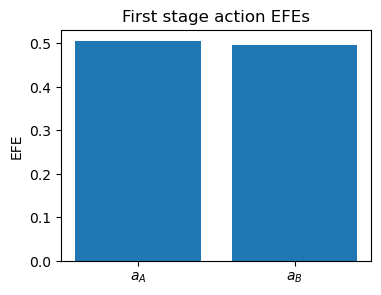

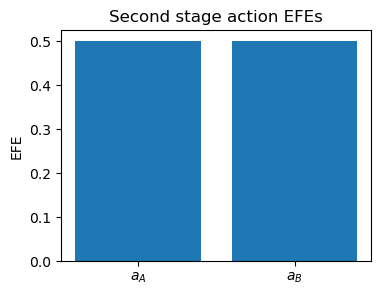

------------------------------------------
TRIAL: 7
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


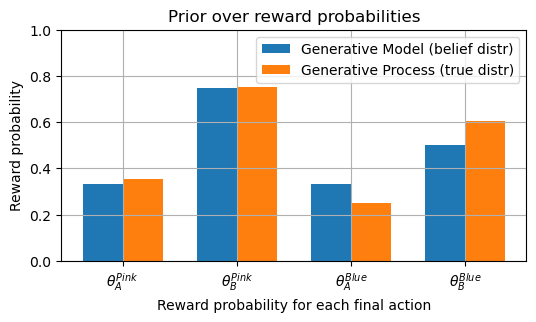

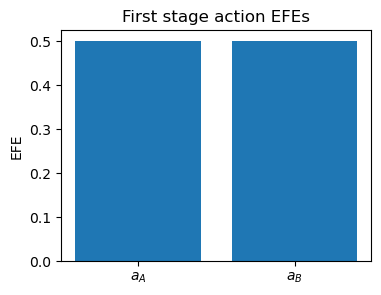

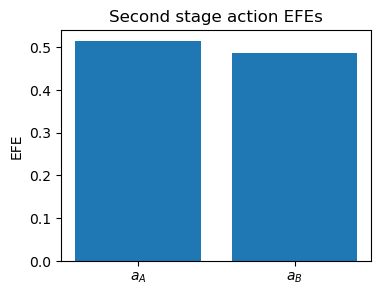

------------------------------------------
TRIAL: 8
First stage action: a_B
Second stage state: PINK
Second stage action: a_B
Observation: 1


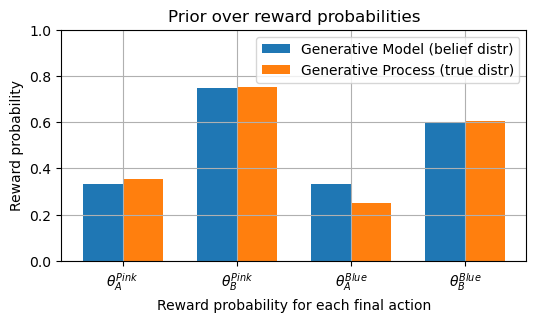

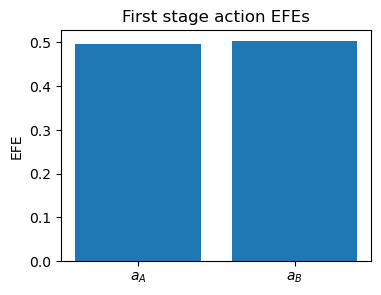

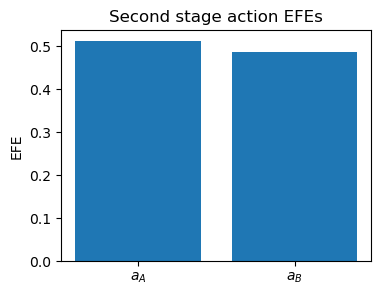

------------------------------------------
TRIAL: 9
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


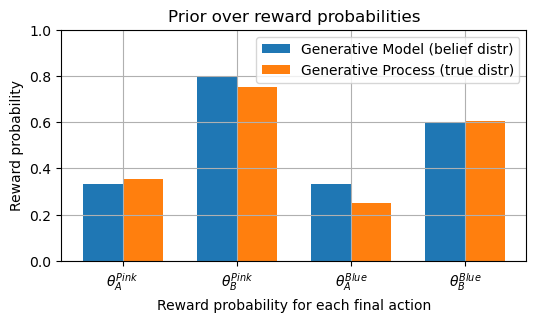

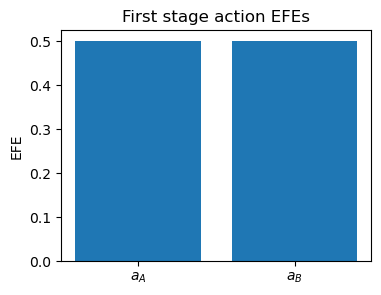

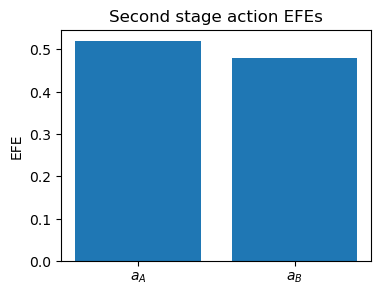

------------------------------------------
TRIAL: 10
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


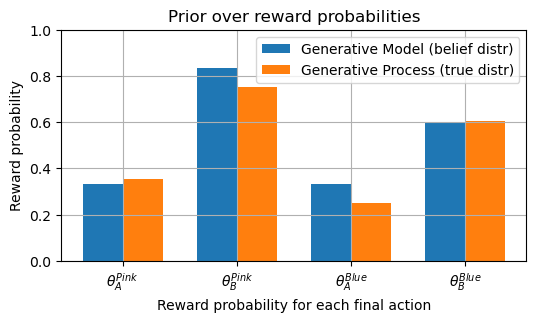

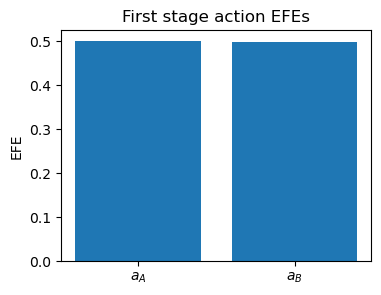

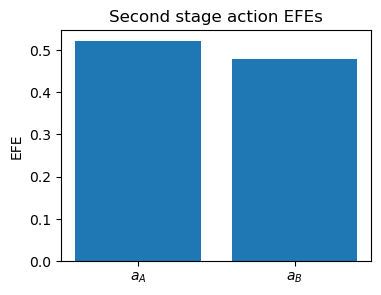

------------------------------------------
TRIAL: 11
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


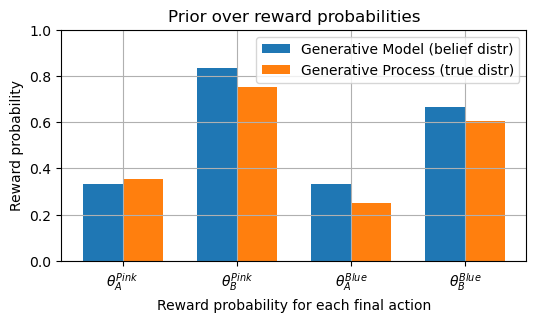

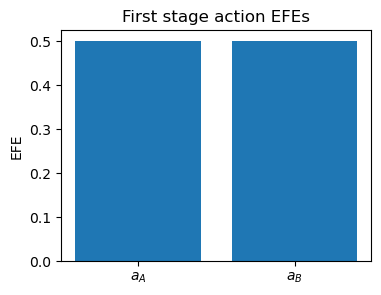

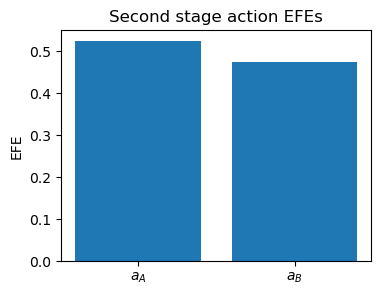

------------------------------------------
TRIAL: 12
First stage action: a_A
Second stage state: BLUE
Second stage action: a_B
Observation: 1


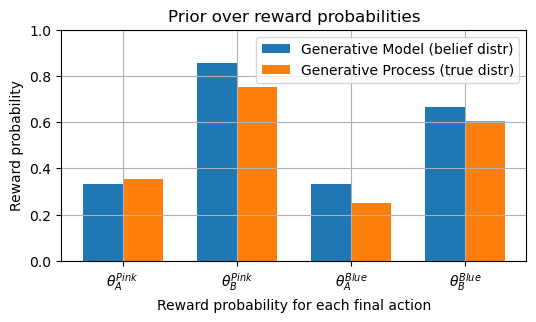

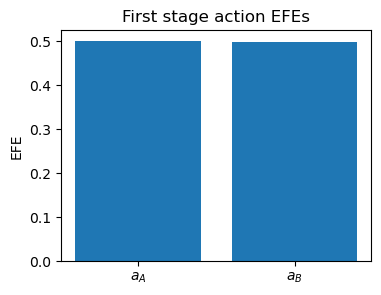

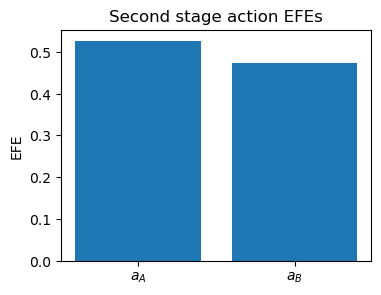

------------------------------------------
TRIAL: 13
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 0


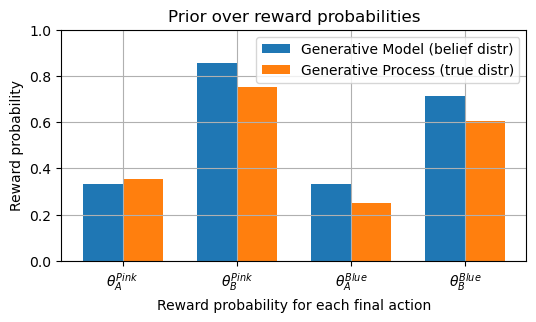

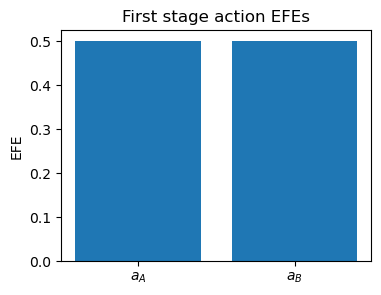

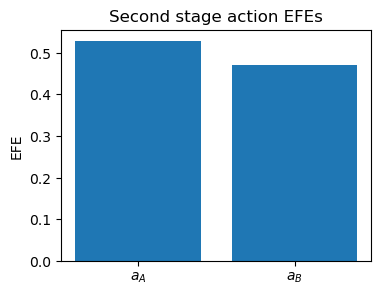

------------------------------------------
TRIAL: 14
First stage action: a_A
Second stage state: BLUE
Second stage action: a_A
Observation: 0


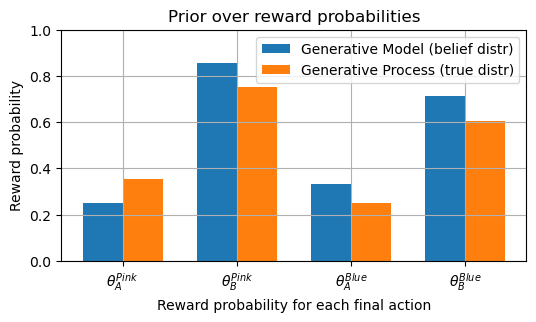

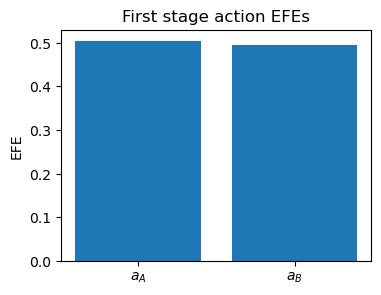

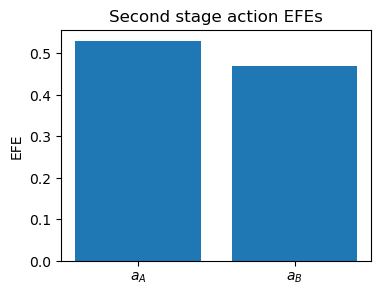

------------------------------------------
TRIAL: 15
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


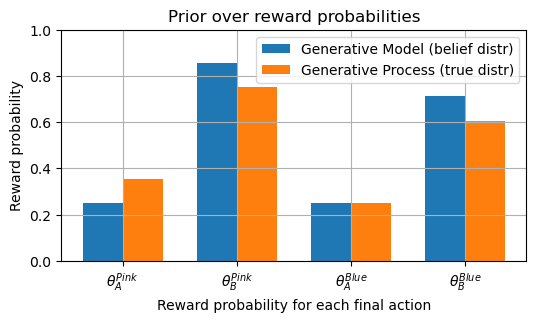

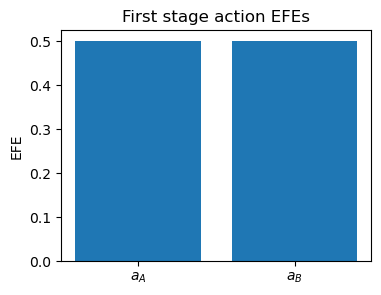

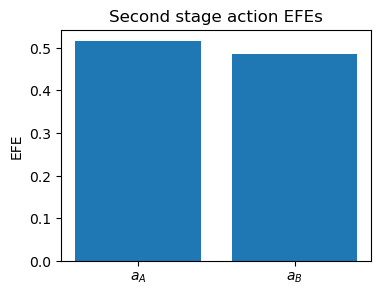

------------------------------------------
TRIAL: 16
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 0


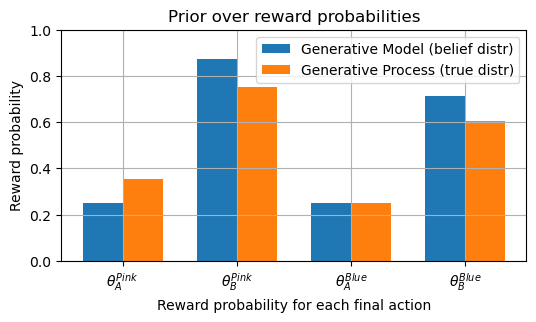

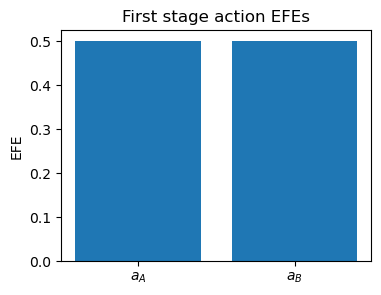

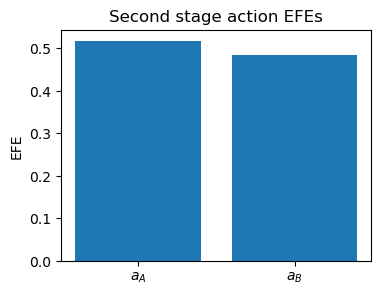

------------------------------------------
TRIAL: 17
First stage action: a_A
Second stage state: PINK
Second stage action: a_A
Observation: 1


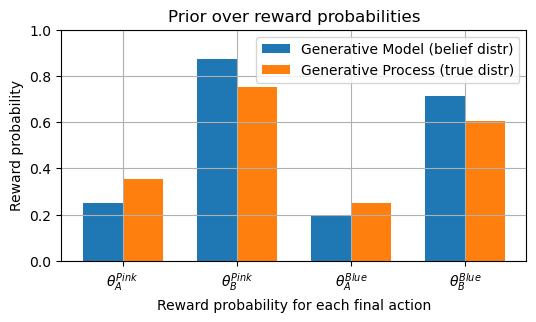

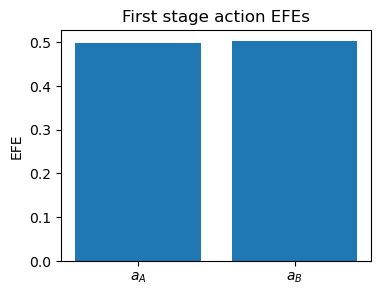

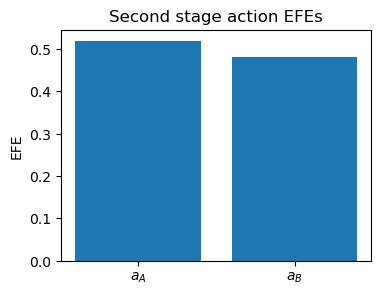

------------------------------------------
TRIAL: 18
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 0


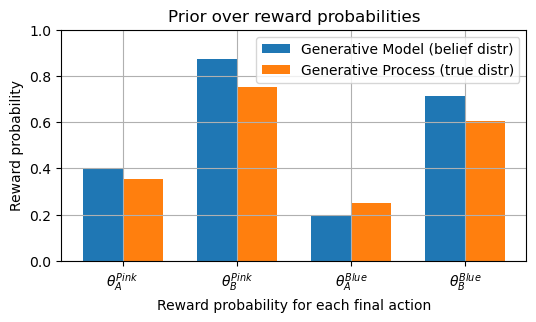

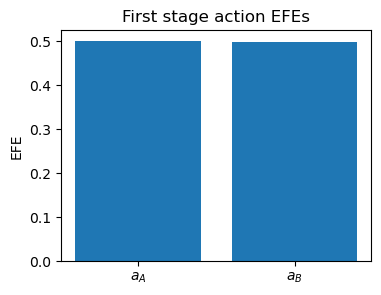

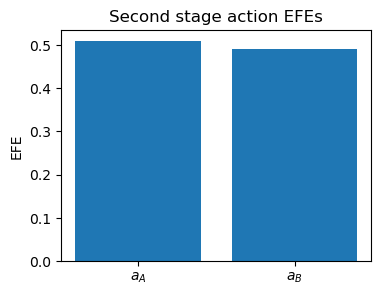

------------------------------------------
TRIAL: 19
First stage action: a_A
Second stage state: BLUE
Second stage action: a_A
Observation: 0


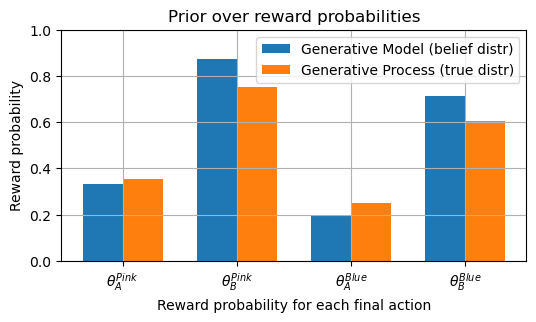

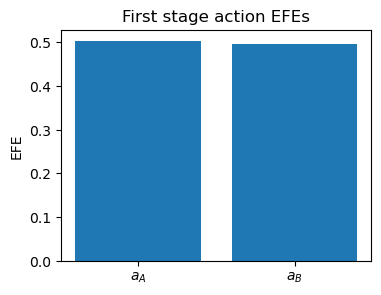

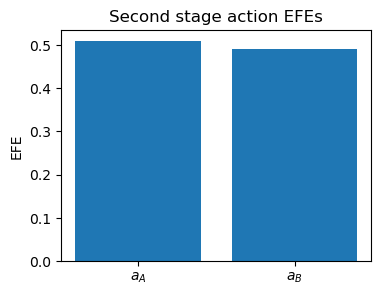

------------------------------------------
TRIAL: 20
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 0


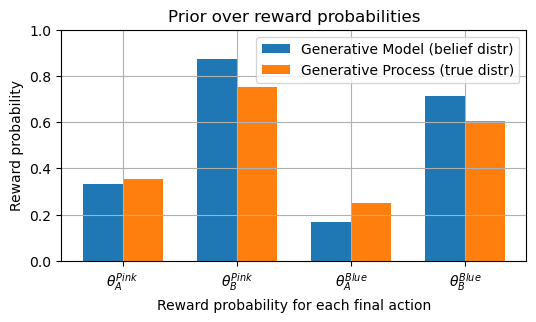

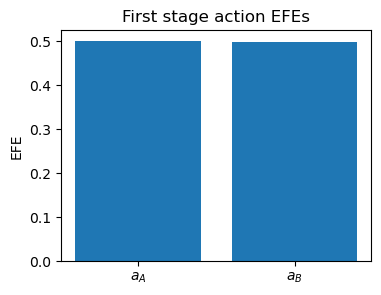

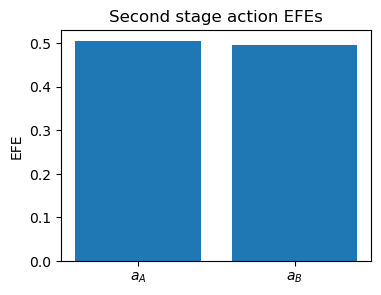

------------------------------------------
TRIAL: 21
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


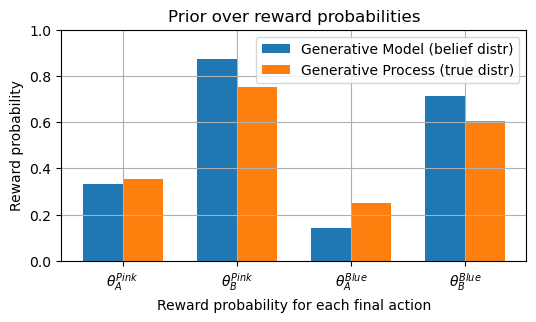

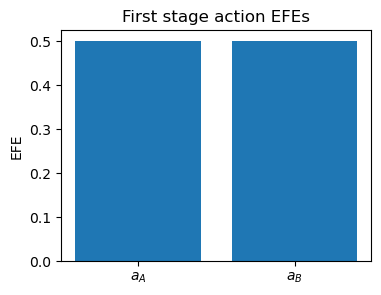

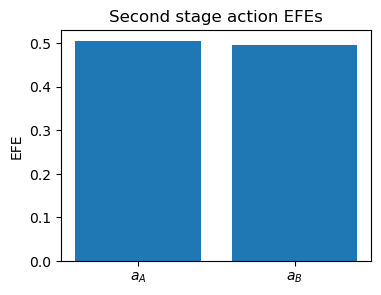

------------------------------------------
TRIAL: 22
First stage action: a_A
Second stage state: PINK
Second stage action: a_A
Observation: 0


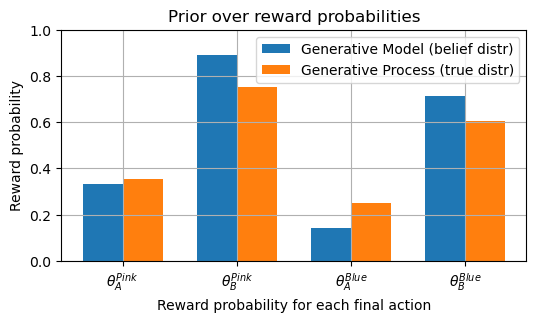

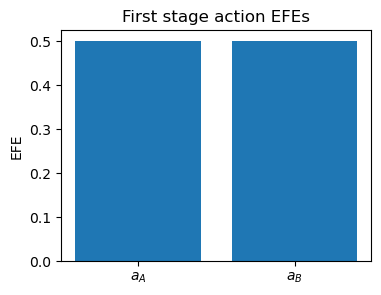

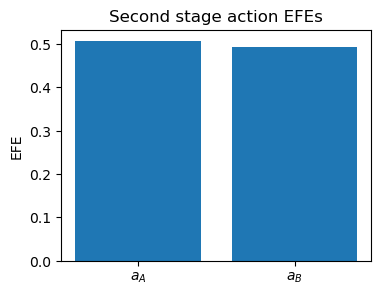

------------------------------------------
TRIAL: 23
First stage action: a_A
Second stage state: BLUE
Second stage action: a_B
Observation: 0


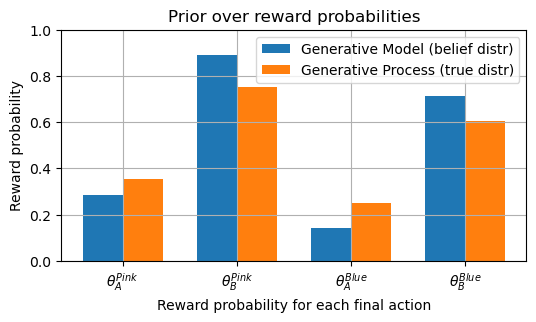

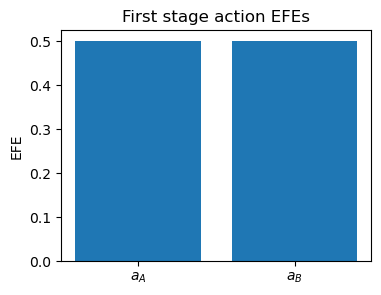

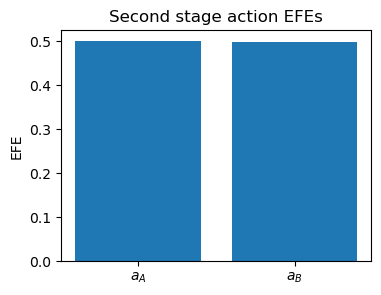

------------------------------------------
TRIAL: 24
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 1


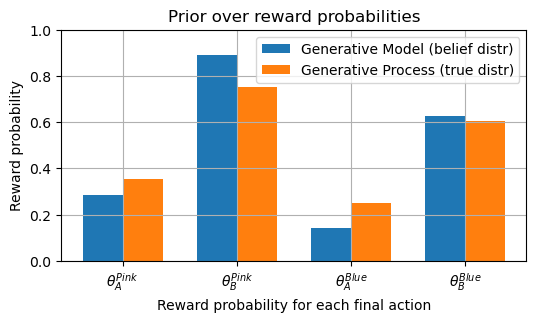

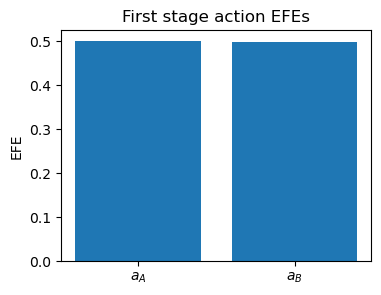

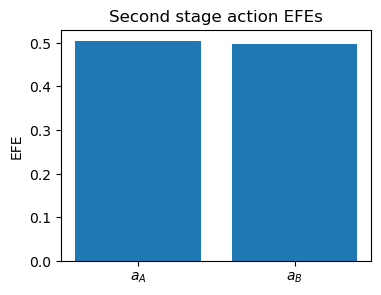

------------------------------------------
TRIAL: 25
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 0


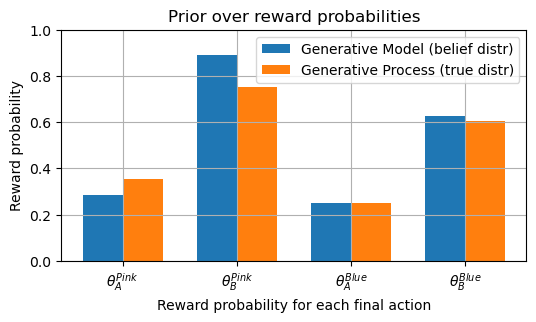

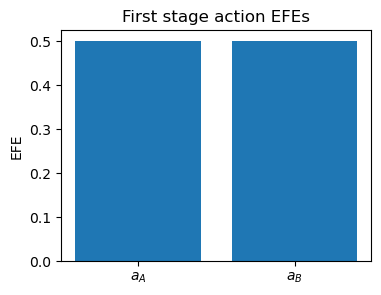

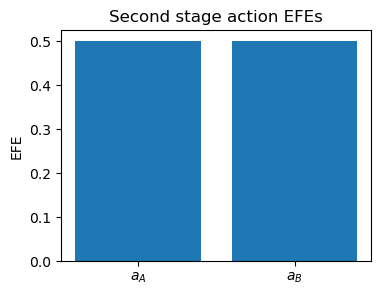

------------------------------------------
TRIAL: 26
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 1


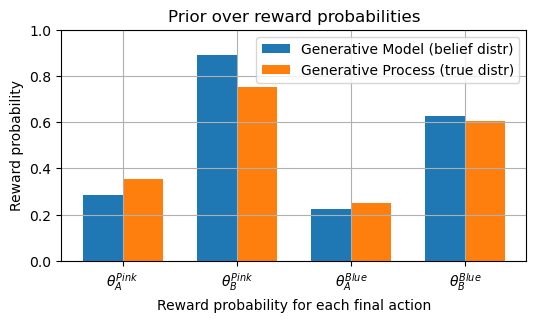

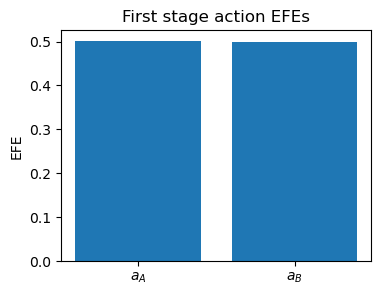

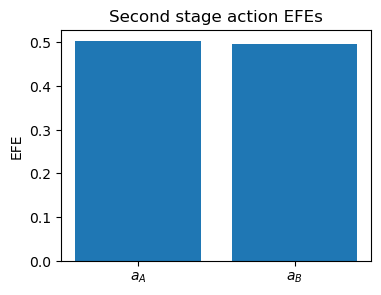

------------------------------------------
TRIAL: 27
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


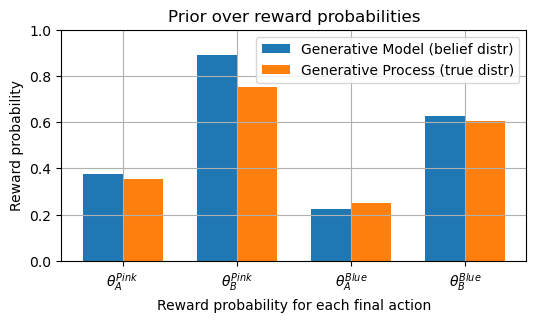

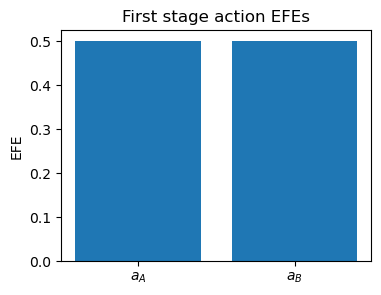

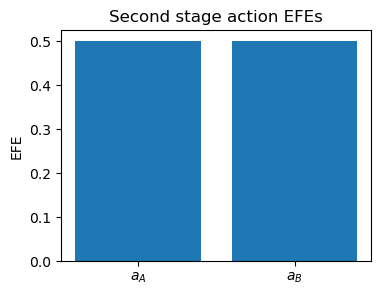

------------------------------------------
TRIAL: 28
First stage action: a_B
Second stage state: PINK
Second stage action: a_B
Observation: 0


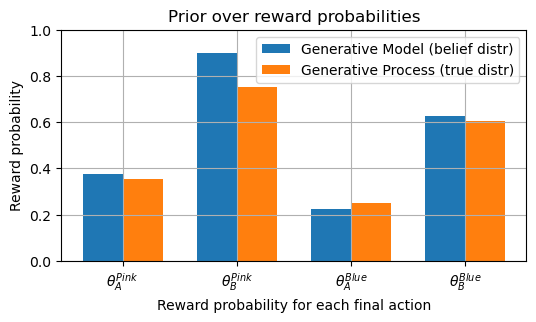

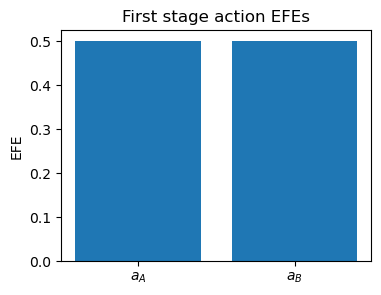

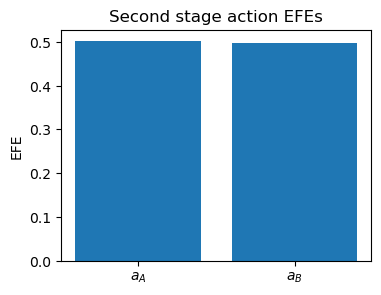

------------------------------------------
TRIAL: 29
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 0


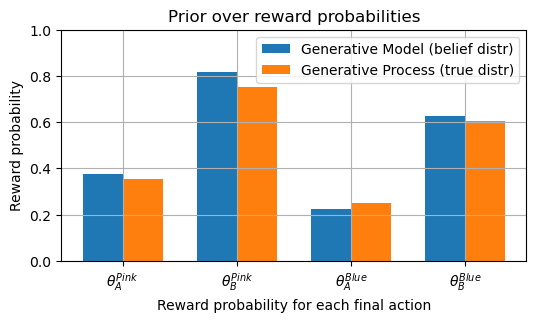

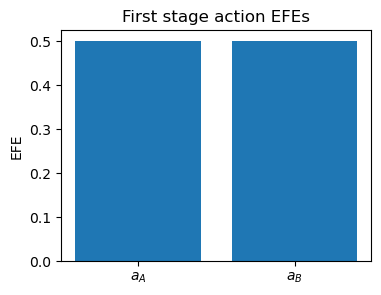

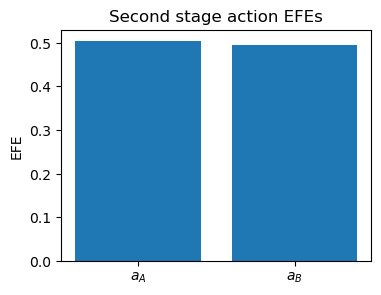

------------------------------------------
TRIAL: 30
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 0


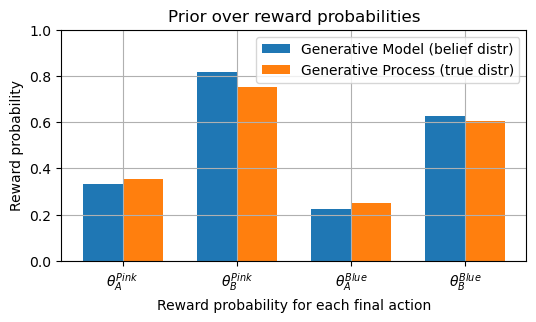

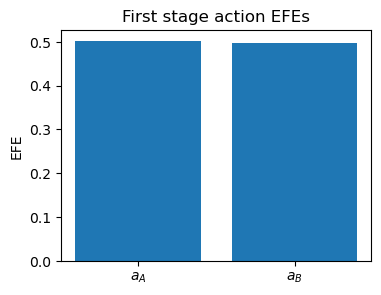

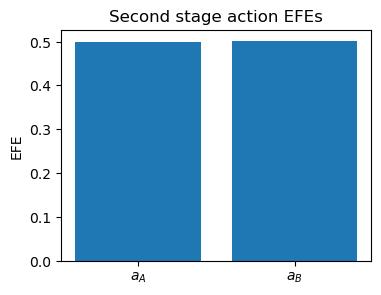

------------------------------------------
TRIAL: 31
First stage action: a_B
Second stage state: PINK
Second stage action: a_B
Observation: 1


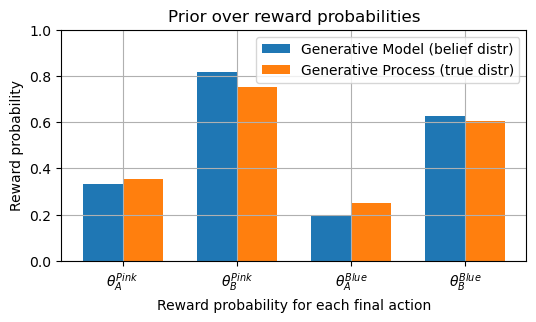

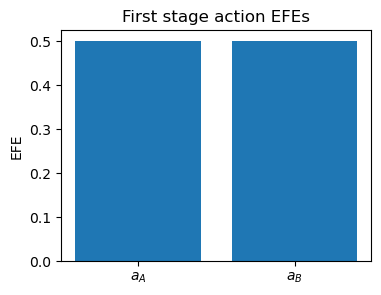

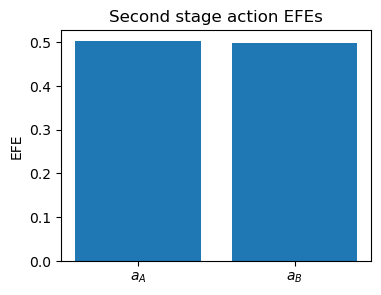

------------------------------------------
TRIAL: 32
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 1


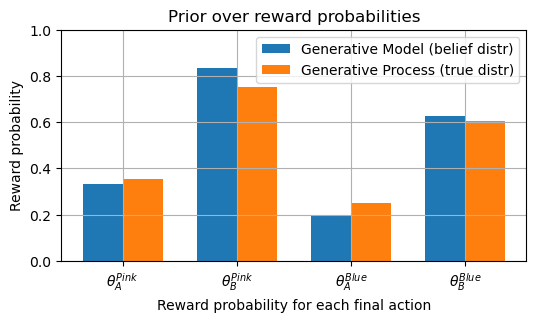

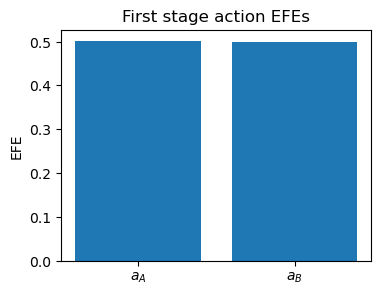

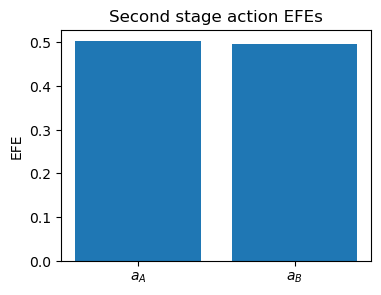

------------------------------------------
TRIAL: 33
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 1


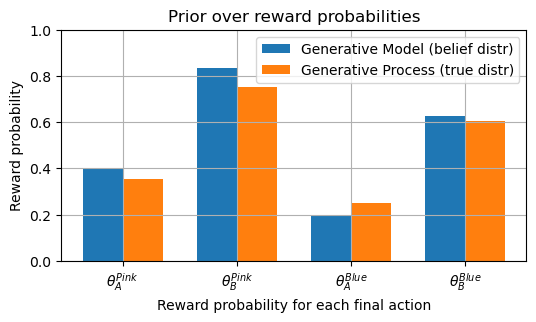

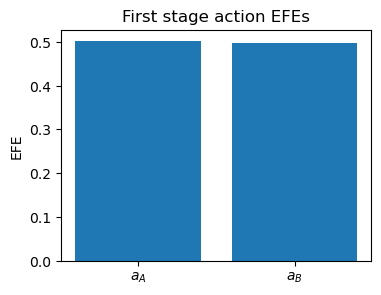

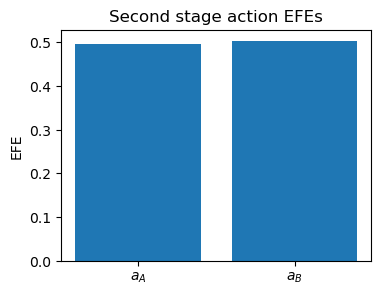

------------------------------------------
TRIAL: 34
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


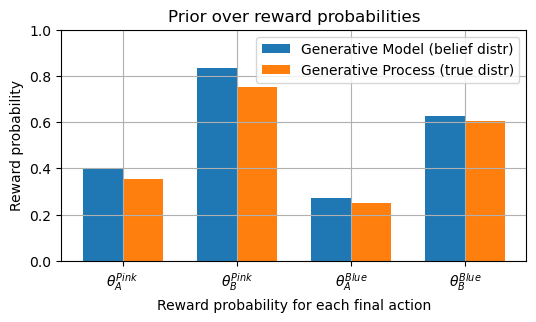

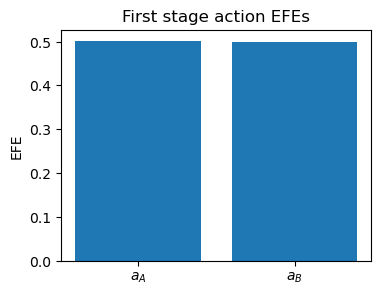

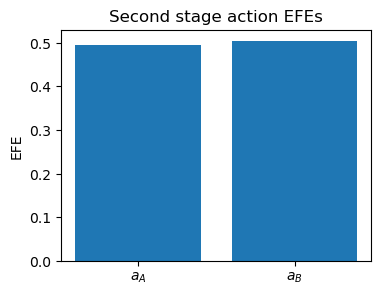

------------------------------------------
TRIAL: 35
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


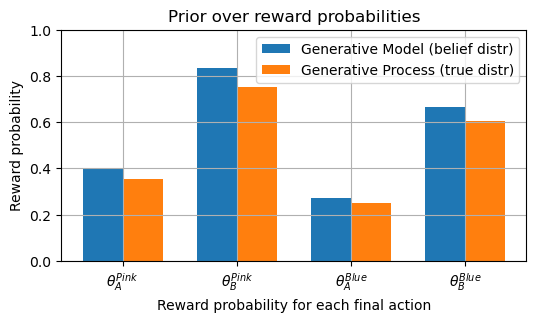

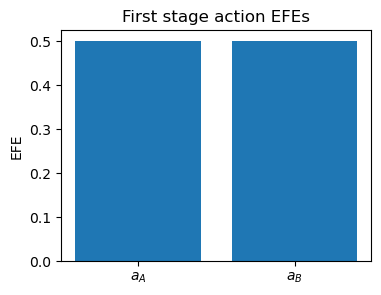

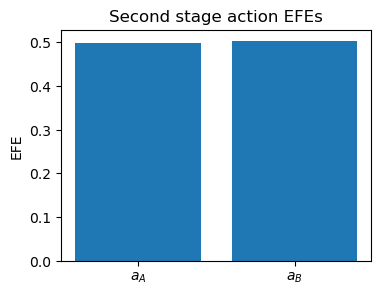

------------------------------------------
TRIAL: 36
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 0


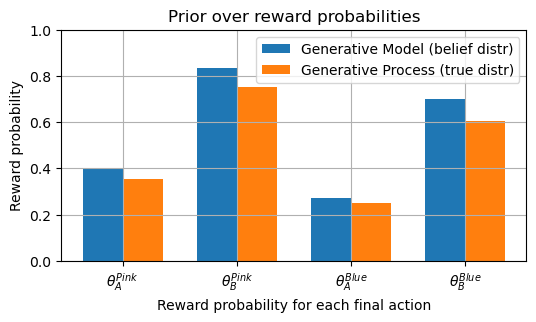

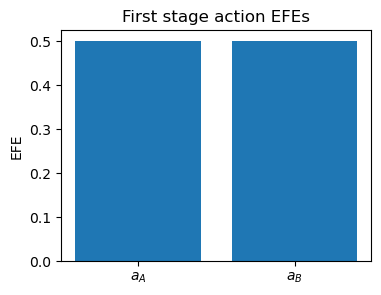

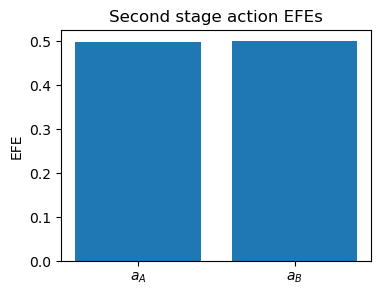

------------------------------------------
TRIAL: 37
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 0


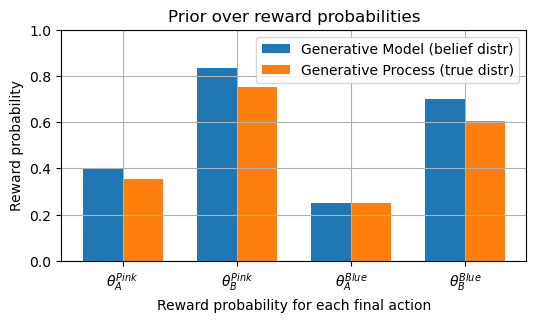

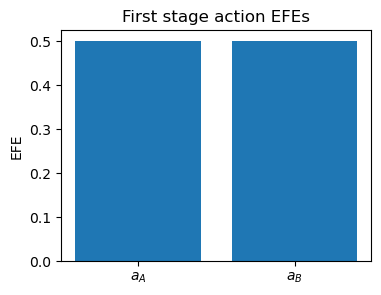

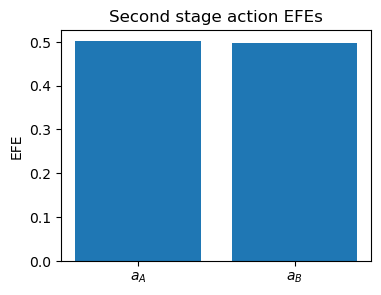

------------------------------------------
TRIAL: 38
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


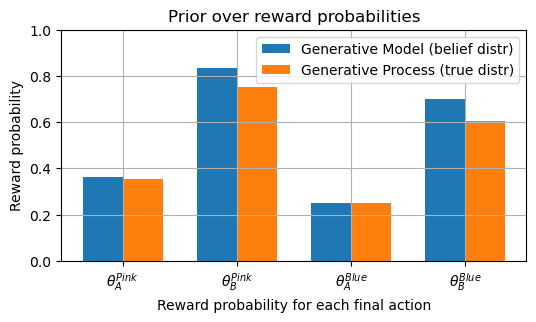

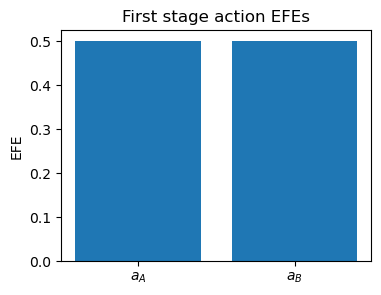

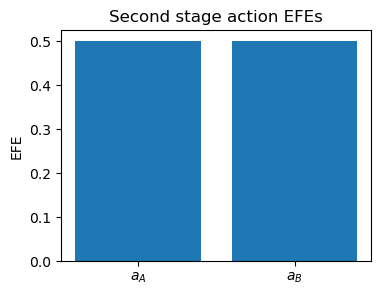

------------------------------------------
TRIAL: 39
First stage action: a_A
Second stage state: BLUE
Second stage action: a_B
Observation: 1


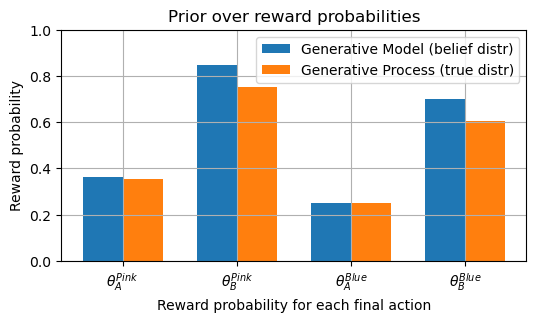

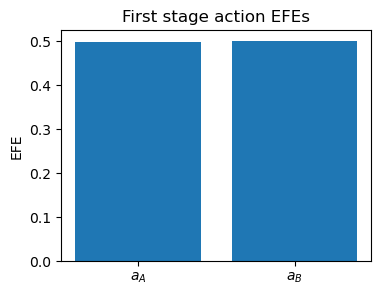

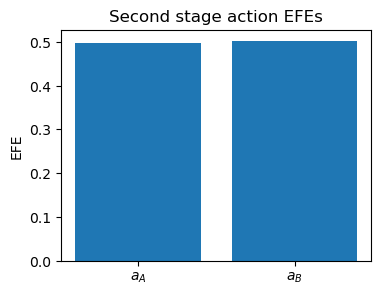

------------------------------------------
TRIAL: 40
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 1


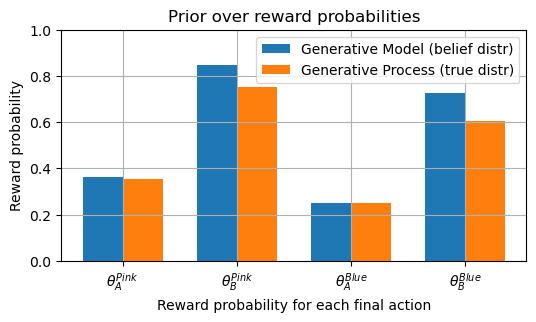

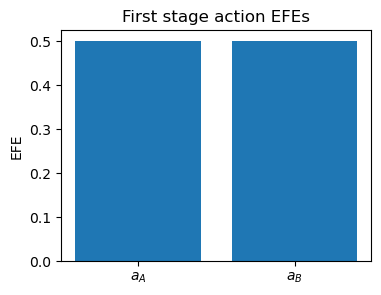

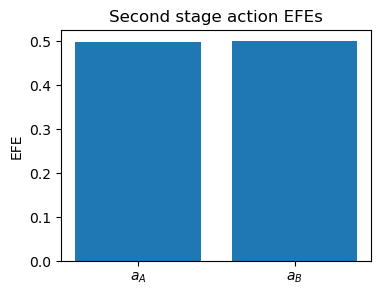

------------------------------------------
TRIAL: 41
First stage action: a_A
Second stage state: BLUE
Second stage action: a_B
Observation: 1


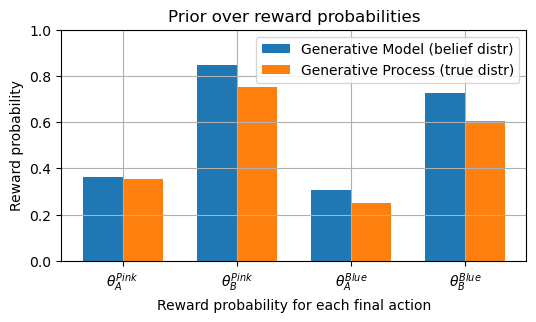

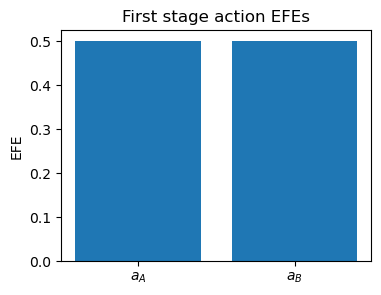

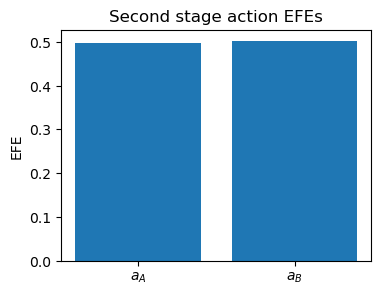

------------------------------------------
TRIAL: 42
First stage action: a_A
Second stage state: BLUE
Second stage action: a_A
Observation: 0


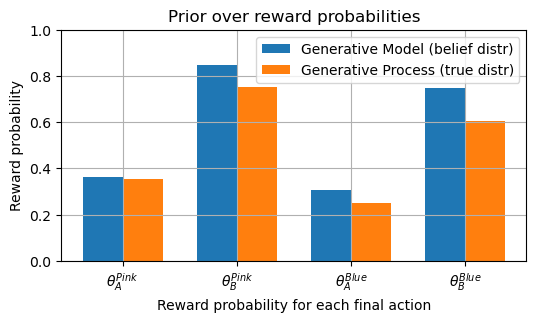

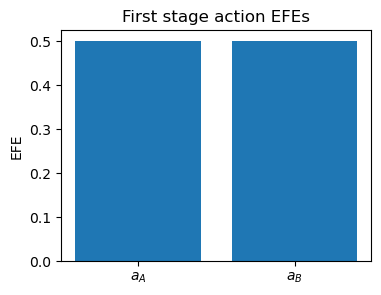

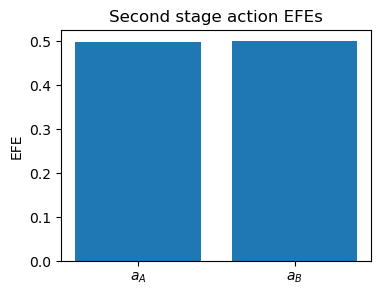

------------------------------------------
TRIAL: 43
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


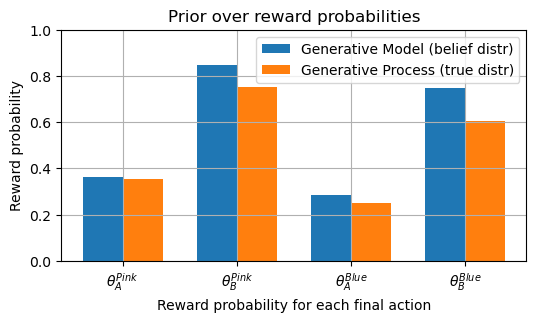

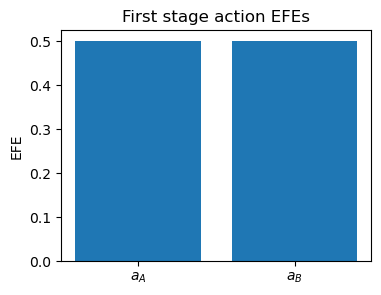

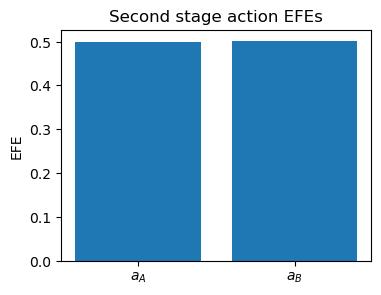

------------------------------------------
TRIAL: 44
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


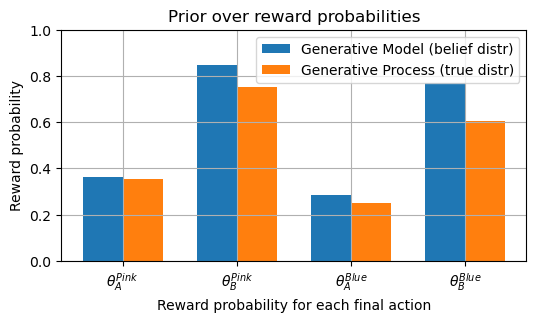

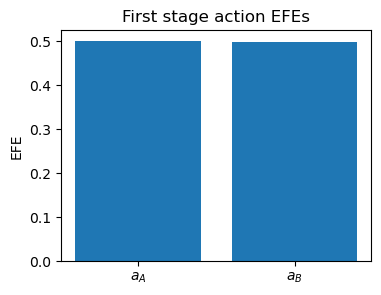

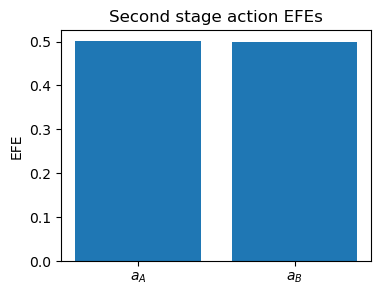

------------------------------------------
TRIAL: 45
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


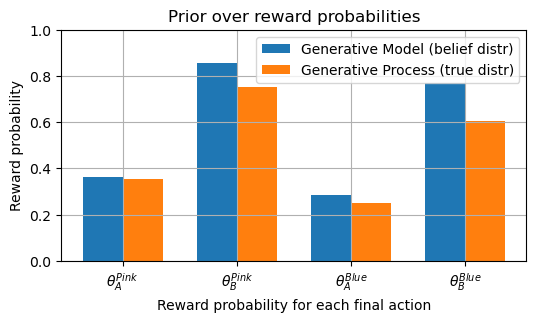

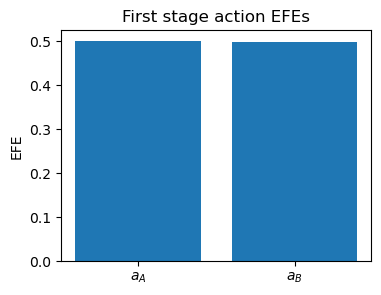

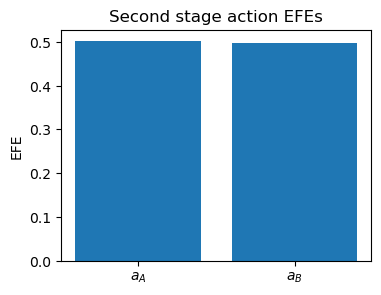

------------------------------------------
TRIAL: 46
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 0


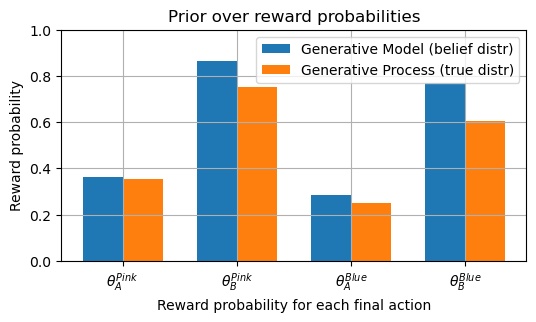

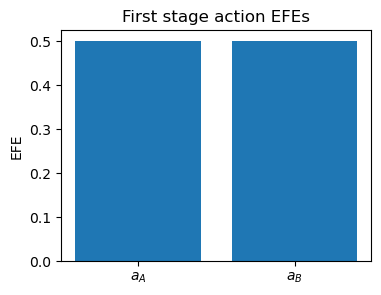

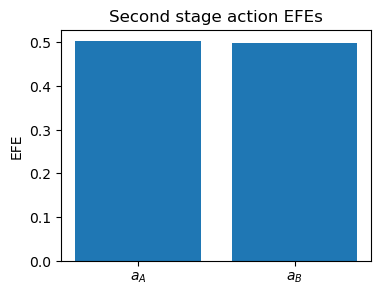

------------------------------------------
TRIAL: 47
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


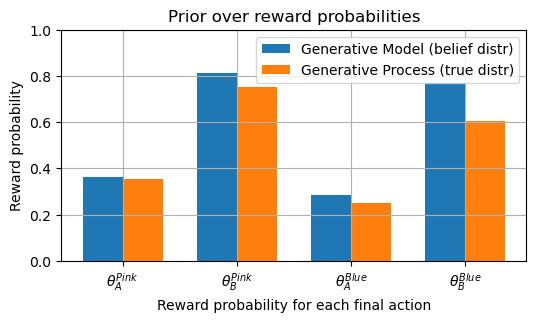

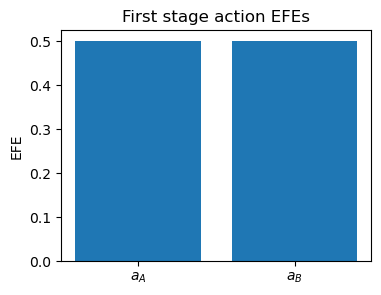

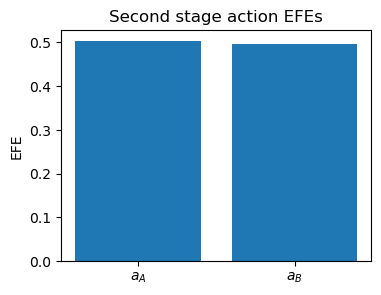

------------------------------------------
TRIAL: 48
First stage action: a_A
Second stage state: BLUE
Second stage action: a_A
Observation: 1


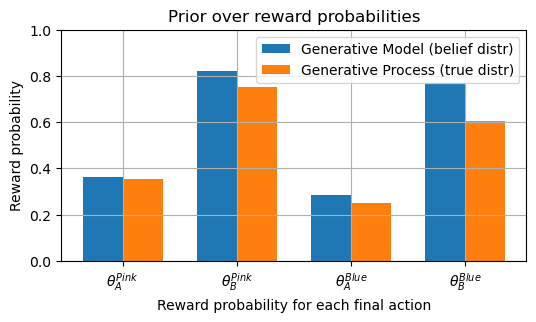

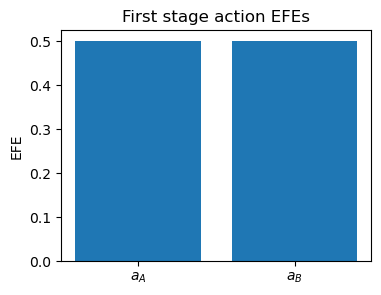

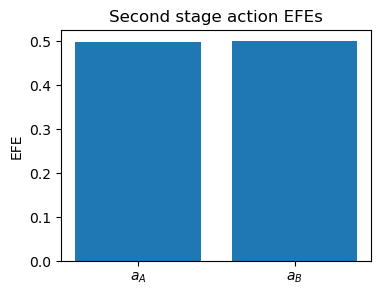

------------------------------------------
TRIAL: 49
First stage action: a_A
Second stage state: PINK
Second stage action: a_A
Observation: 0


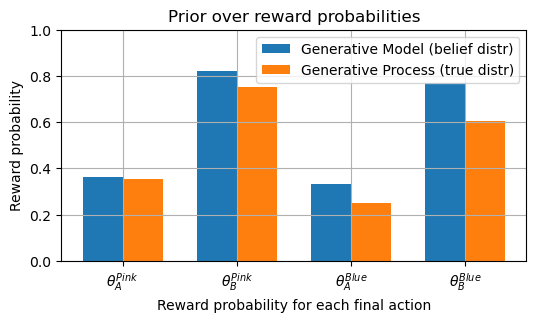

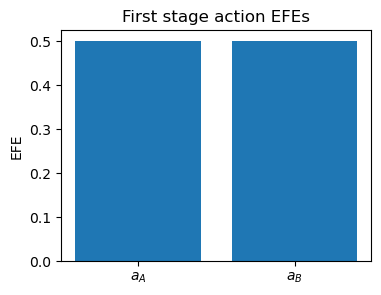

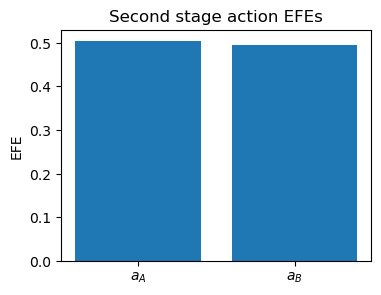

------------------------------------------
TRIAL: 50
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


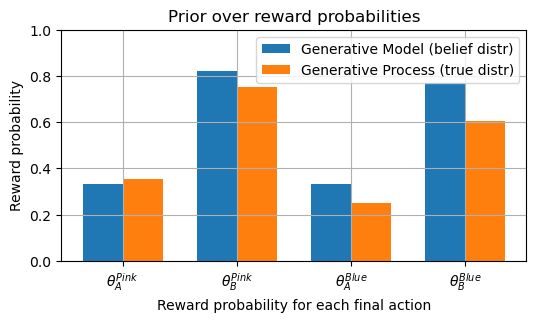

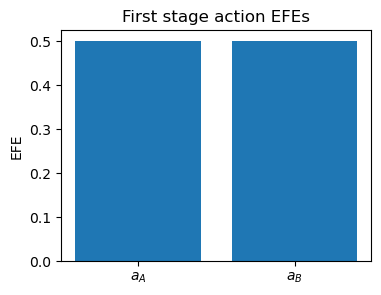

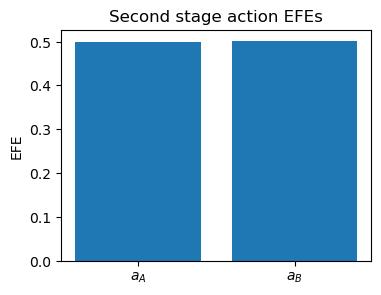

------------------------------------------
TRIAL: 51
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 0


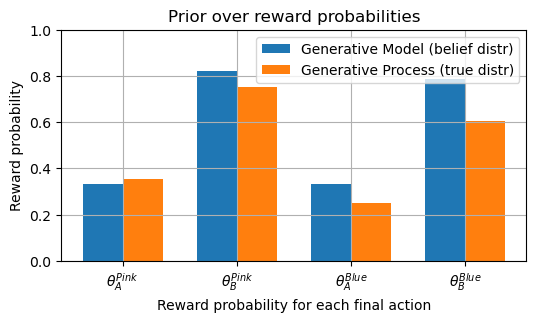

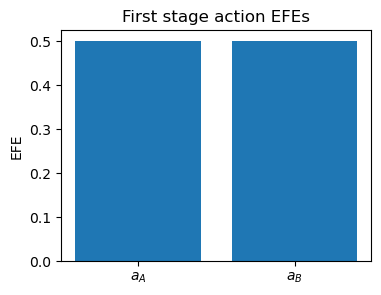

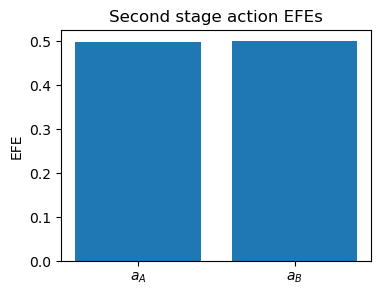

------------------------------------------
TRIAL: 52
First stage action: a_B
Second stage state: BLUE
Second stage action: a_B
Observation: 1


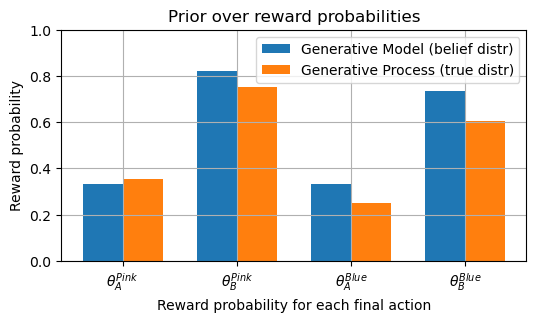

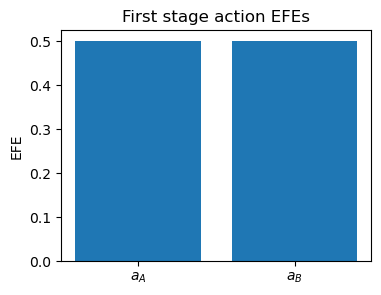

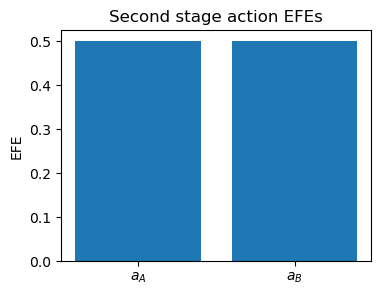

------------------------------------------
TRIAL: 53
First stage action: a_B
Second stage state: PINK
Second stage action: a_A
Observation: 0


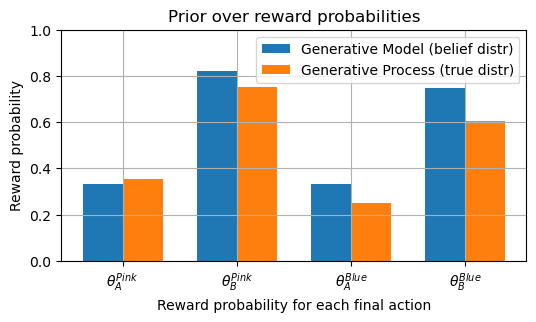

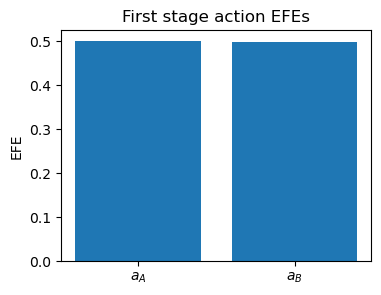

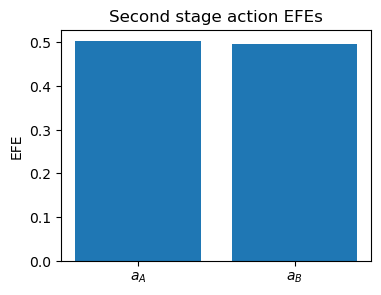

------------------------------------------
TRIAL: 54
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 0


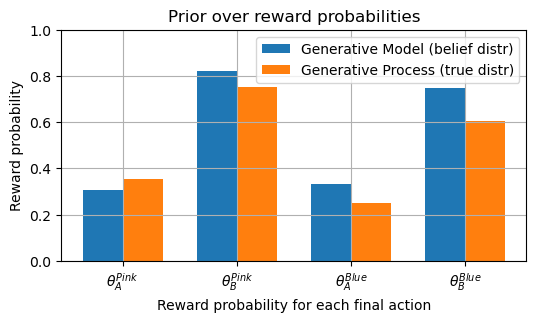

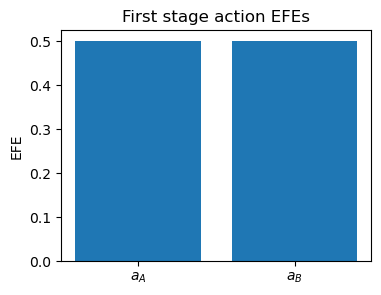

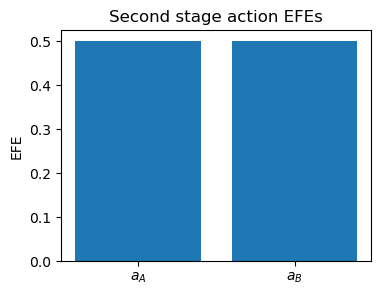

------------------------------------------
TRIAL: 55
First stage action: a_A
Second stage state: PINK
Second stage action: a_A
Observation: 1


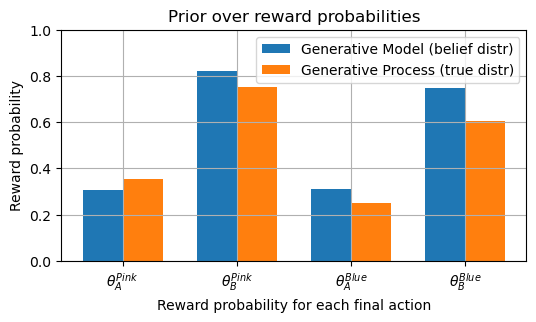

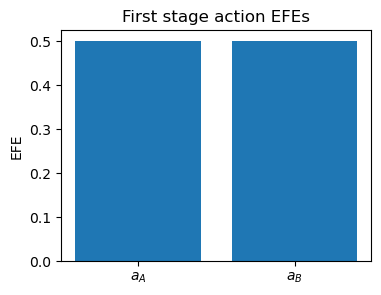

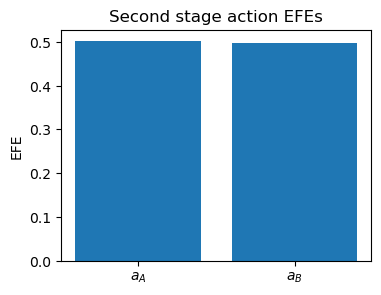

------------------------------------------
TRIAL: 56
First stage action: a_A
Second stage state: PINK
Second stage action: a_A
Observation: 1


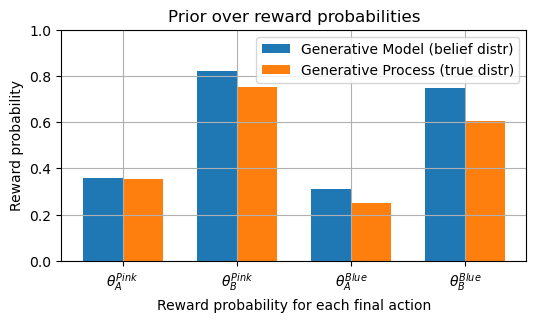

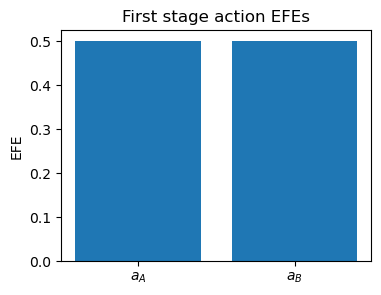

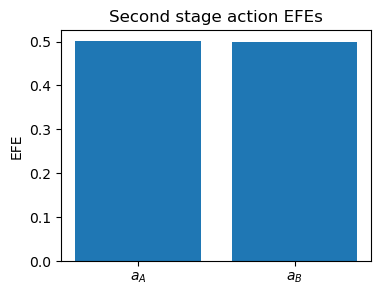

------------------------------------------
TRIAL: 57
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 0


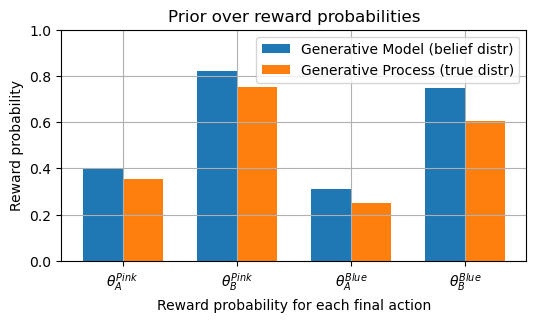

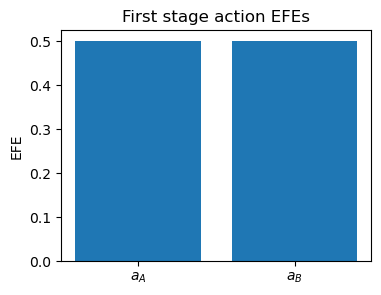

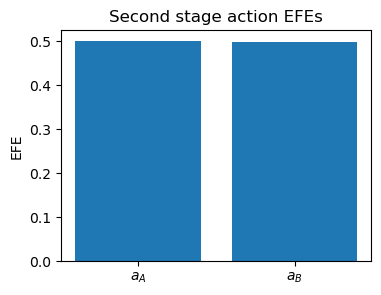

------------------------------------------
TRIAL: 58
First stage action: a_A
Second stage state: PINK
Second stage action: a_B
Observation: 1


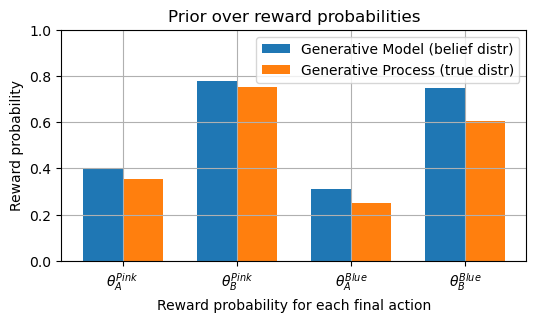

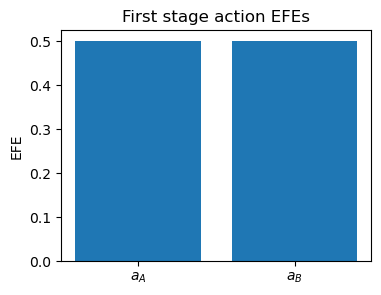

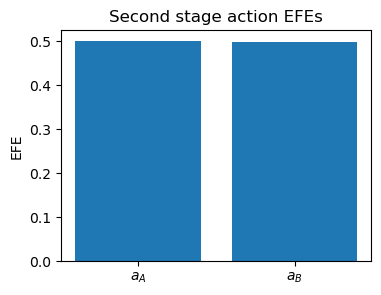

------------------------------------------
TRIAL: 59
First stage action: a_B
Second stage state: BLUE
Second stage action: a_A
Observation: 0


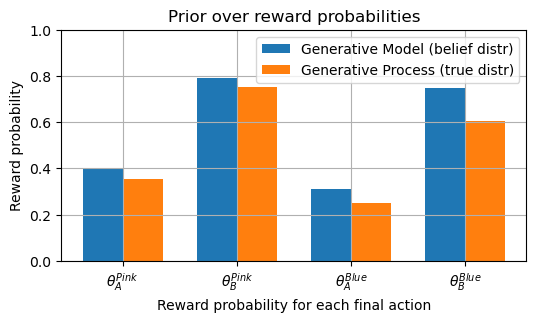

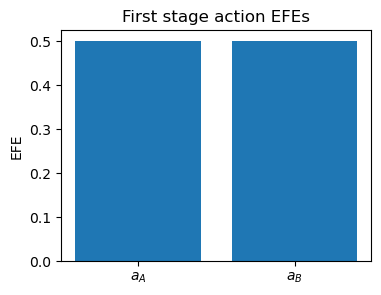

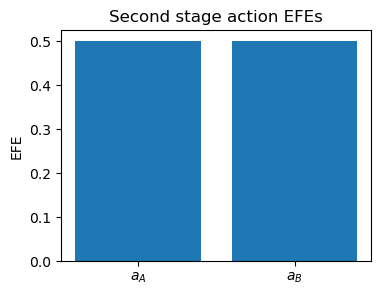

------------------------------------------
TRIAL: 60
First stage action: a_B
Second stage state: PINK
Second stage action: a_B
Observation: 1


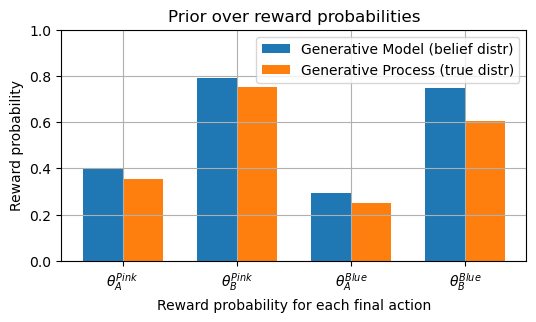

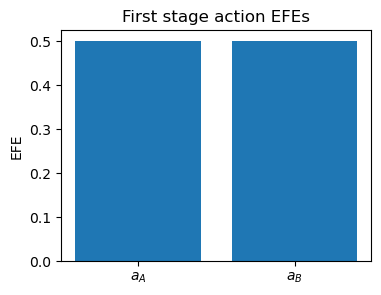

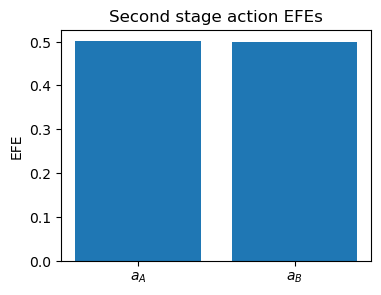

------------------------------------------


In [166]:
Plot_agent_performing_task(actions, observations, pi, p_trans, p_r, Gs)

In [227]:
n_agents = 50

n_trials = 200

model_dict["lam"] = 10

task_dict["T"] = n_trials

rewards = np.zeros((n_agents,n_trials))

surprise = np.zeros((n_agents,n_trials))

from scipy.spatial import distance


distr_dist = np.zeros((n_agents,n_trials))

for a in tqdm(range(n_agents)): 
    agent = learn_and_act(task = task_dict, model = model_dict , seed = a+1)
    actions, observations, pi, p_trans, p_r, Gs = agent.perform_task()
    rewards[a] = observations[:,1]
    
    for t in range(n_trials):
        
        trial_observations = observations[t]
        
        trial_actions = actions[t]
        
        trial_action_first_stage = trial_actions[0]
        
        trial_action_second_stage = trial_actions[1]
        
        second_stage_state = trial_observations[0]
        
        reward = trial_observations[1] 
        
        pi_interesting = pi[t,1]
        
        theta_BA = pi_interesting[1,2]/(pi_interesting[0,2] + pi_interesting[1,2]) 
        theta_BB = pi_interesting[1,3]/(pi_interesting[0,3] + pi_interesting[1,3])
        theta_CA = pi_interesting[1,4]/(pi_interesting[0,4] + pi_interesting[1,4])
        theta_CB = pi_interesting[1,5]/(pi_interesting[0,5] + pi_interesting[1,5])
        
        gen_model_probs = [theta_BA, theta_BB, theta_CA, theta_CB] 
        
        gen_process_probs = [p_r[0,0,t], p_r[0,1,t], p_r[1,0,t], p_r[1,1,t]] 
        
        distr_dist[a,t] = distance.jensenshannon(gen_model_probs, gen_process_probs)
        
        if second_stage_state == 0:
            if trial_action_second_stage == 0:
                p_belief = theta_BA
            else:
                p_belief = theta_BB        
        else:
            if trial_action_second_stage == 0:
                p_belief = theta_CA
            else: 
                p_belief = theta_CB
        
        if reward == 0:
            surprise[a,t] = -np.log(1-p_belief)
        else:
            surprise[a,t] = -np.log(p_belief)
            
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.17it/s]


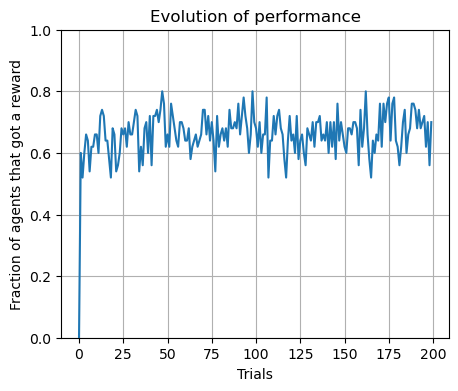

In [228]:
mean_rewards = np.average(rewards,axis = 0)

plt.figure(figsize=(5, 4))
plt.title("Evolution of performance")
plt.ylabel("Fraction of agents that got a reward")
plt.xlabel("Trials")
plt.ylim(0,1)
plt.grid()
plt.plot(mean_rewards)
plt.show()

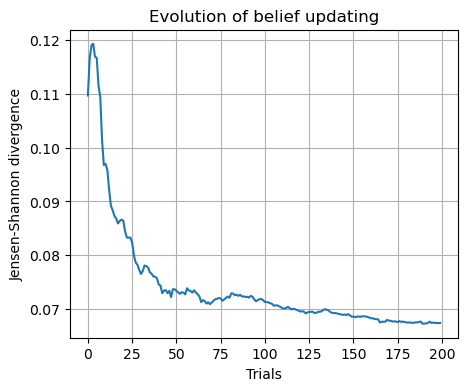

In [230]:
mean_dist = np.average(distr_dist,axis = 0)

plt.figure(figsize=(5, 4))
plt.title("Evolution of belief updating")
plt.ylabel("Jensen-Shannon divergence")
plt.xlabel("Trials")
plt.grid()
plt.plot(mean_dist)
plt.show()

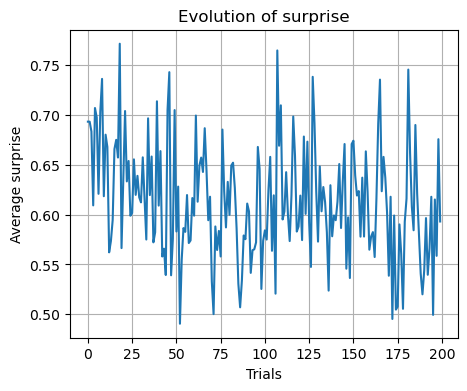

In [221]:
mean_surprise = np.average(surprise,axis = 0)

plt.figure(figsize=(5, 4))
plt.title("Evolution of surprise")
plt.ylabel("Average surprise")
plt.xlabel("Trials")
plt.grid()
plt.plot(mean_surprise)
plt.show()